# Noisy gates simulation

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator, SuperOp, average_gate_fidelity

from spin_pulse import ExperimentalEnvironment, HardwareSpecs, PulseCircuit, Shape
from spin_pulse.noise import NoiseType

In [2]:
n_qb = 1

B0, delta, J_coupling = 0.3, 0.3, 0.03
ramp_dur = 0
T2 = 50
duration = 25

## Idle qubits

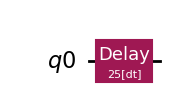

In [3]:
delay_circ = QuantumCircuit(QuantumRegister(1))
delay_circ.delay(duration)
delay_circ.draw("mpl")

### Coherent noise

In [4]:
hardware_specs = HardwareSpecs(
    num_qubits=n_qb,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.Square,
    ramp_duration=ramp_dur,
)

exp_env_coherent = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.COHERENT,
    T2=T2,
    duration=1000 * duration,
    segment_duration=duration,
)

In [5]:
pulse_circ_coherent = PulseCircuit.from_circuit(delay_circ, hardware_specs)
channel_coherent = pulse_circ_coherent.mean_channel(exp_env_coherent)

100%|██████████| 1000/1000 [00:01<00:00, 524.04it/s]


In [6]:
from spin_pulse.average_channel import pauli_dict_to_channel, plot_chi_matrix


def contrast_channel(C):
    return pauli_dict_to_channel({"II": (1 + C) / 2, "ZZ": (1 - C) / 2})


C_coherent = np.exp(-(duration**2 / T2**2))

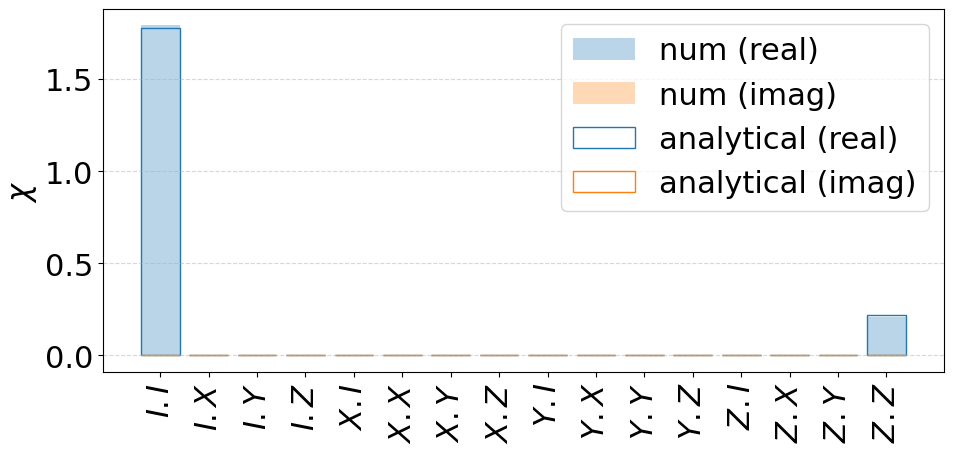

In [7]:
fig = plot_chi_matrix(
    {"num": channel_coherent, "analytical": contrast_channel(C_coherent)}
)
# fig.savefig('../paper/fig4a.pdf',bbox_inches='tight')

### White noise

In [8]:
exp_env_white = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.WHITE,
    T2=T2,
    duration=1000 * duration,
    segment_duration=1,
)

In [9]:
pulse_circ_white = PulseCircuit.from_circuit(delay_circ, hardware_specs)

channel_white = pulse_circ_white.mean_channel(exp_env_white)

100%|██████████| 1000/1000 [00:01<00:00, 769.90it/s]


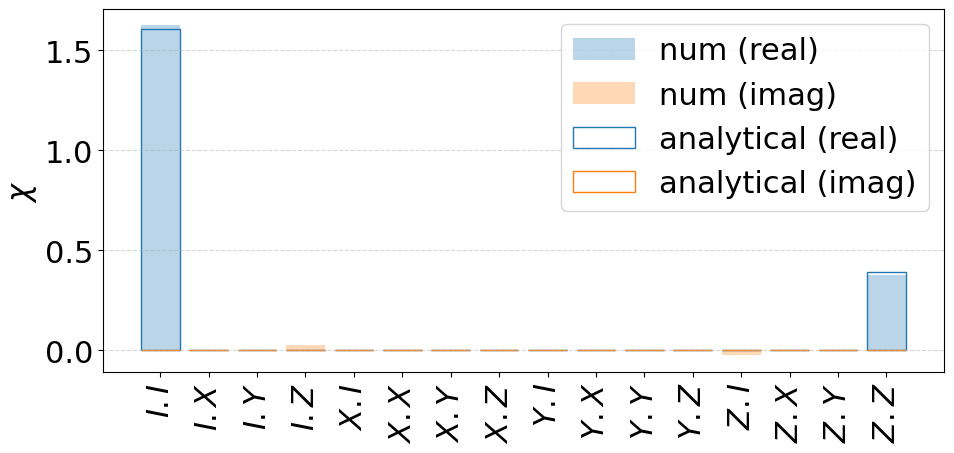

In [10]:
C_white = np.exp(-duration / T2)
fig = plot_chi_matrix({"num": channel_white, "analytical": contrast_channel(C_white)})
# fig.savefig('../paper/fig4b.pdf',bbox_inches='tight')

### Pink noise

In [11]:
exp_env_pink = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2=T2,
    duration=1000 * duration,
    segment_duration=1000 * duration,
)
pulse_circ_pink = PulseCircuit.from_circuit(delay_circ, hardware_specs)
channel_pink = pulse_circ_pink.mean_channel(exp_env_pink)

100%|██████████| 1000/1000 [00:00<00:00, 1012.58it/s]


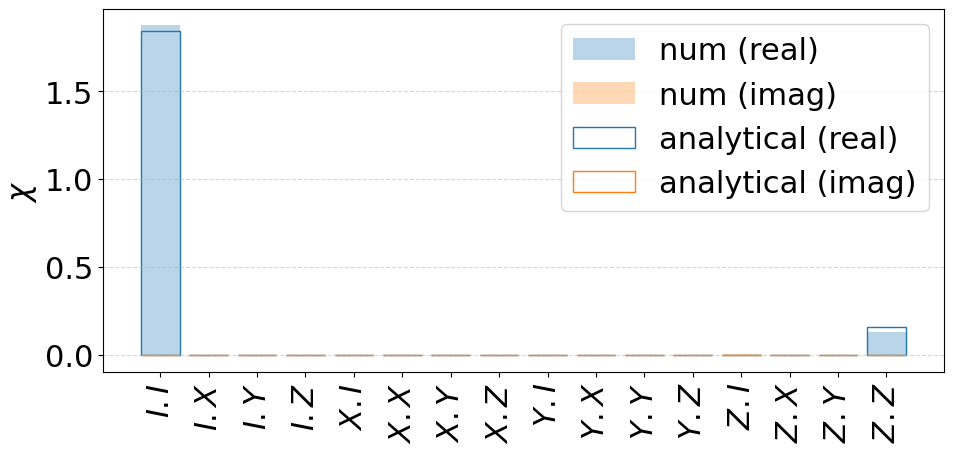

In [12]:
T2_duration = 1 / (
    2
    * np.pi
    * np.sqrt(exp_env_pink.time_traces[0].S0 * np.log(exp_env_pink.duration / duration))
)
C_pink = np.exp(-(duration**2) / (T2_duration**2))
fig = plot_chi_matrix({"num": channel_pink, "analytical": contrast_channel(C_pink)})
# fig.savefig('../paper/fig4c.pdf',bbox_inches='tight')

## X Gate

### Coherent noise

In [13]:
B0 = 0.1  # We increase the single qubit gate time to amplify noise effects, to make them visible in our plots

hardware_specs = HardwareSpecs(
    num_qubits=n_qb,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.Square,
    ramp_duration=ramp_dur,
)

In [14]:
x_circ = QuantumCircuit(QuantumRegister(1))
x_circ.rx(np.pi, 0)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.COHERENT,
    T2=T2,
    duration=1000
    * pulse_circ_x.duration,  # we take the coherent duration to be exactly the circuit duration
    segment_duration=pulse_circ_x.duration,
)


channel_x_coherent = pulse_circ_x.mean_channel(exp_env)

100%|██████████| 1000/1000 [00:01<00:00, 686.88it/s]


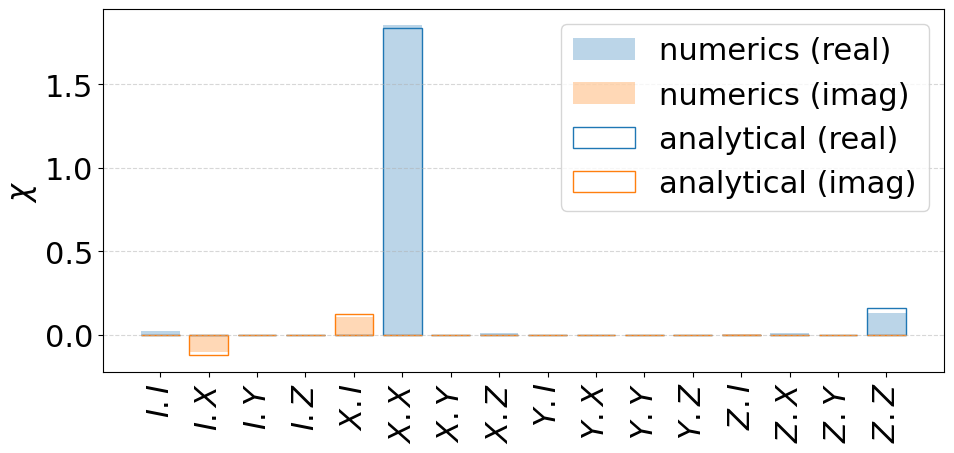

In [15]:
sigma = exp_env.time_traces[0].sigma
x_chan_pauli = {
    "XX": 1 - sigma**2 / B0**2,
    "IX": 1j * np.pi * sigma**2 / (4 * B0**2),
    "XI": -1j * np.pi * sigma**2 / (4 * B0**2),
    "ZZ": sigma**2 / B0**2,
}
channel_x_coherent_analytics = pauli_dict_to_channel(x_chan_pauli)
fig = plot_chi_matrix(
    {"numerics": channel_x_coherent, "analytical": channel_x_coherent_analytics}
)
# fig.savefig('../paper/fig4d.pdf',bbox_inches='tight')

### White noise

In [16]:
exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.WHITE,
    T2=T2,
    duration=2**14,
    segment_duration=1,
)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)
channel_x_white = pulse_circ_x.mean_channel(exp_env)

100%|██████████| 528/528 [00:01<00:00, 424.51it/s]


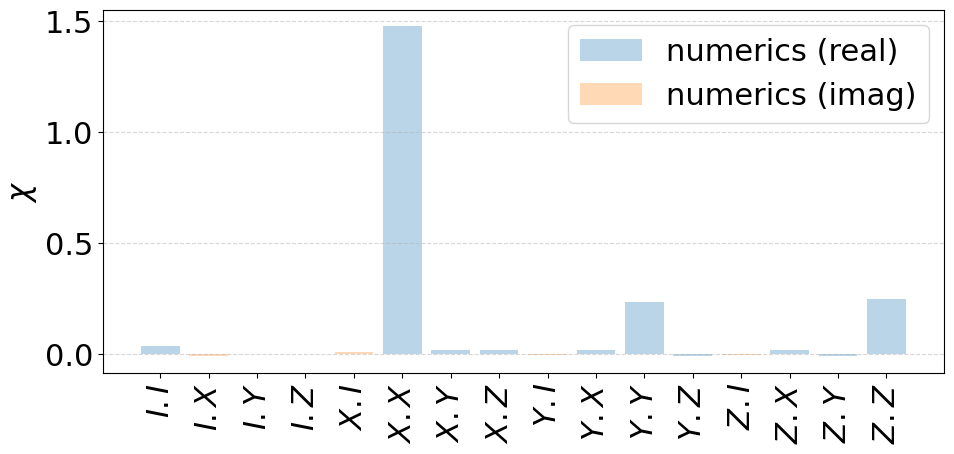

In [17]:
fig = plot_chi_matrix({"numerics": channel_x_white})
# fig.savefig('../paper/fig4e.pdf',bbox_inches='tight')

### Pink Noise

In [18]:
exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2=T2,
    duration=2**14,
    segment_duration=2**14,
)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)
channel_x_pink = pulse_circ_x.mean_channel(exp_env)

100%|██████████| 528/528 [00:01<00:00, 501.92it/s]


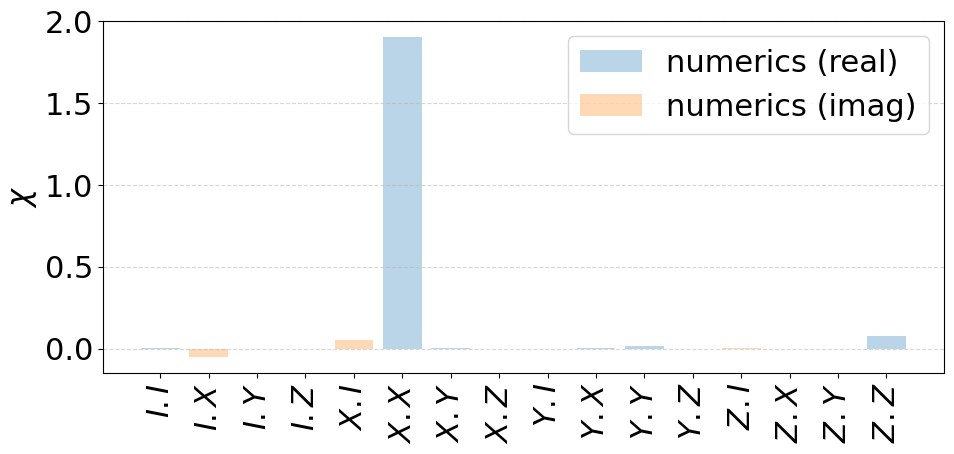

In [19]:
fig = plot_chi_matrix({"numerics": channel_x_pink})
# fig.savefig('../paper/fig4f.pdf',bbox_inches='tight')

<!-- Let us use a realization of full-drive DD (i.e. a $2n\pi$ X rotation over the idle period) to an idle qubit.

We start with an analytical example with coherent noise -->

## Two-qubit gate

In [20]:
n_qb_2 = 2
B0, delta, J_coupling = 0.3, 0.3, 0.03
ramp_dur = 10
T2 = 2000

In [ ]:
def get_relative_channel(hardware_specs, noise_type):
    circ_2q = QuantumCircuit(QuantumRegister(2))
    circ_2q.rzz(np.pi / 2, 0, 1)
    isa_circ_2q = hardware_specs.gate_transpile(circ_2q)

    pulse_circ_2q = PulseCircuit.from_circuit(isa_circ_2q, hardware_specs)

    if noise_type == NoiseType.COHERENT:
        segment_duration = pulse_circ_2q.duration
        duration = 1000 * segment_duration
    elif noise_type == NoiseType.WHITE:
        segment_duration = 1
        duration = 1000 * pulse_circ_2q.duration
    else:
        segment_duration = 1000 * pulse_circ_2q.duration
        duration = 1000 * pulse_circ_2q.duration

    exp_env = ExperimentalEnvironment(
        hardware_specs=hardware_specs,
        noise_type=noise_type,
        T2=T2,
        duration=duration,
        segment_duration=segment_duration,
    )

    channel_2q = pulse_circ_2q.mean_channel(exp_env)
    relative_channel_2q = channel_2q.compose(SuperOp(isa_circ_2q).adjoint())

    fidelity = average_gate_fidelity(channel_2q, Operator(isa_circ_2q))

    return relative_channel_2q, fidelity, pulse_circ_2q.duration

In [ ]:
hardware_specs = HardwareSpecs(
    num_qubits=2,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.GAUSSIAN,
    ramp_duration=ramp_dur,
)

noise_types = [NoiseType.COHERENT, NoiseType.WHITE, NoiseType.PINK]
results = [get_relative_channel(hardware_specs, _) for _ in noise_types]
relative_channel_2q = [_[0] for _ in results]
fidelity = [_[1] for _ in results]
circuit_duration = results[0][2]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:14<00:00, 68.38it/s]


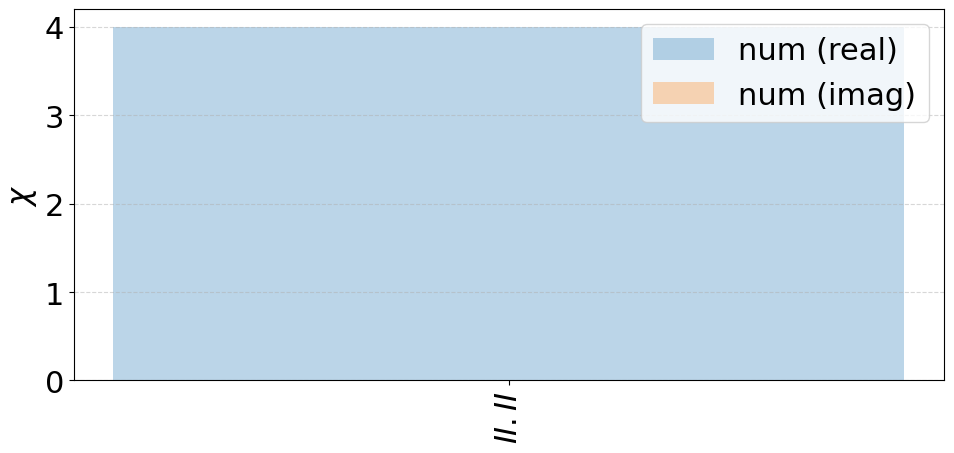

In [23]:
fig = plot_chi_matrix({"num": relative_channel_2q[0]}, threshold=1e-2)
# fig.savefig('../paper/fig4g.pdf',bbox_inches='tight')

In [24]:
C_se = np.exp(-circuit_duration / T2)
relative_channel_2q_analytics = contrast_channel(C_se).tensor(contrast_channel(C_se))

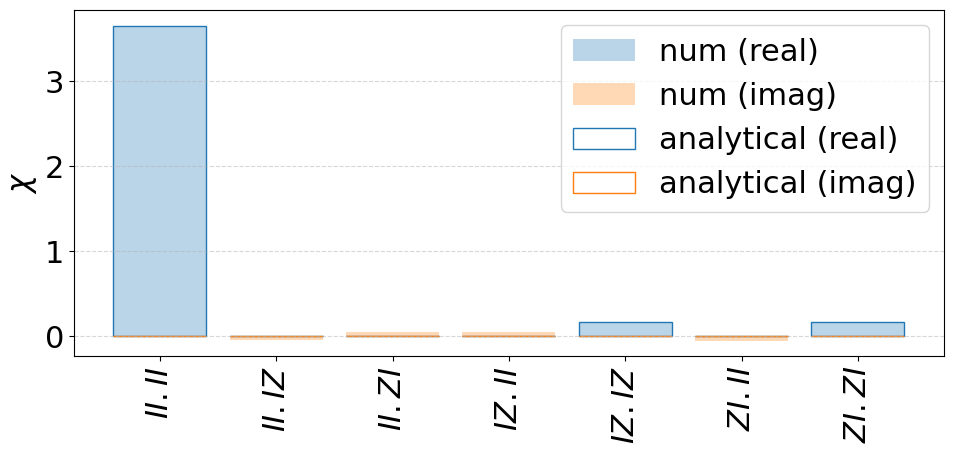

In [25]:
fig = plot_chi_matrix(
    {"num": relative_channel_2q[1], "analytical": relative_channel_2q_analytics},
    threshold=1e-2,
)
# fig.savefig('../paper/fig4h.pdf',bbox_inches='tight')

In [26]:
print("Numerical fidelity ", fidelity[1])
print("Analytical fidelity ", (1 + 4 * C_se) / 5)

Numerical fidelity  0.9299893146154684
Analytical fidelity  0.9274983475745853


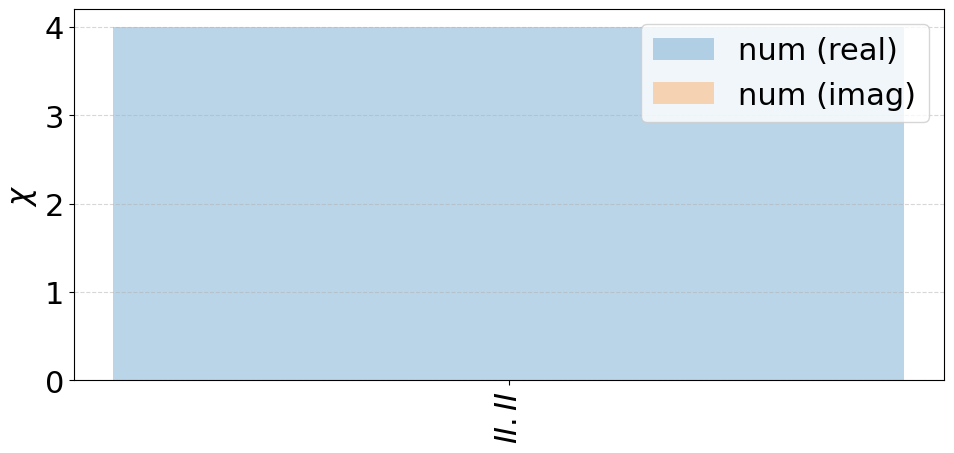

In [27]:
fig = plot_chi_matrix({"num": relative_channel_2q[2]}, threshold=1e-2)
# fig.savefig('../paper/fig4i.pdf',bbox_inches='tight')

## Gate exchange noise

In [28]:
ramp_dur = 5
J_coupling = 0.005
T2 = 1_000_000
TJ = 500
hardware_specs = HardwareSpecs(
    num_qubits=n_qb_2,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.Square,
    ramp_duration=ramp_dur,
)

circ_2q = QuantumCircuit(QuantumRegister(2))
circ_2q.rzz(np.pi / 2, 0, 1)
isa_circ_2q = hardware_specs.gate_transpile(circ_2q)

pulse_circ_2q = PulseCircuit.from_circuit(isa_circ_2q, hardware_specs)

duration = pulse_circ_2q.duration

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.COHERENT,
    T2=T2,
    duration=duration,
    segment_duration=duration,
    TJ=TJ,
)

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2=T2,
    duration=1000 * duration,
    segment_duration=1000 * duration,
    TJ=TJ,
)

In [29]:
channel_2q = pulse_circ_2q.mean_channel(exp_env)
relative_channel_2q = channel_2q.compose(SuperOp(isa_circ_2q).adjoint())
fidelity = average_gate_fidelity(channel_2q, Operator(isa_circ_2q))

100%|██████████| 1000/1000 [00:24<00:00, 41.32it/s]


In [30]:
twoq_duration = (
    2
    * pulse_circ_2q.pulse_layers[1]
    .twoq_pulse_sequences[0]
    .pulse_instructions[1]
    .duration
)

0.9356917714836479
0.930572101369649


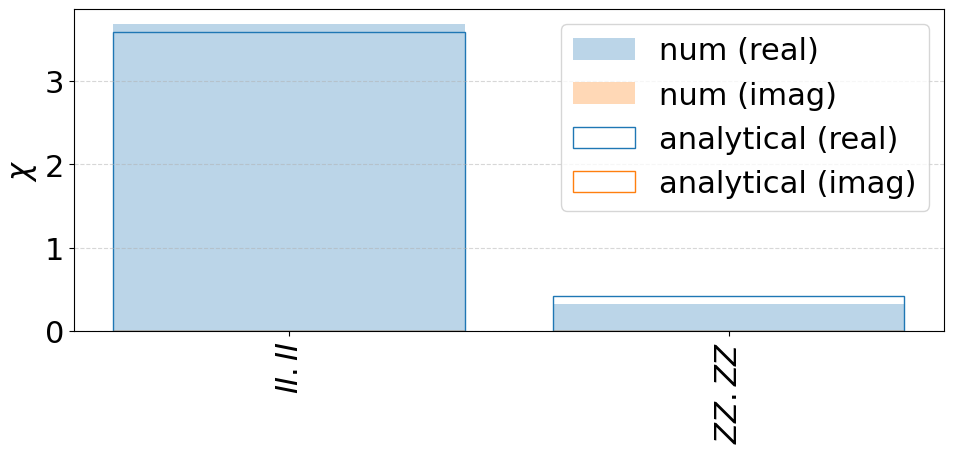

In [31]:
TJ_duration = 1 / (
    2
    * np.pi
    * np.sqrt(
        exp_env.time_traces_coupling[0].S0 * np.log(exp_env.duration / twoq_duration)
    )
)

C = np.exp(-(twoq_duration**2) / TJ_duration**2)

twoq_contrast_channel = pauli_dict_to_channel(
    {"IIII": (1 + C) / 2, "ZZZZ": (1 - C) / 2}
)
fig = plot_chi_matrix(
    {"num": relative_channel_2q, "analytical": twoq_contrast_channel}, threshold=1e-2
)

fidelity_analytics = (2 + C) / 3
print(fidelity)
print(fidelity_analytics)